In [23]:
import numpy as np
import seaborn as sns
import pandas as pd

In [24]:
df = pd.read_csv("amazon_reviews.csv")
df.head()

,Reviews,label
0,This product so far has not disappointed. My c...,spam
1,great for beginner or experienced person. Boug...,spam
2,Inexpensive tablet for him to use and learn on...,spam
3,I've had my Fire HD 8 two weeks now and I love...,ham
4,I bought this for my grand daughter when she c...,ham


In [25]:
df.shape

(5002, 2)

1. Data cleaning

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5002 entries, 0 to 5001
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  5002 non-null   object
 1   label    5002 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [27]:
df.label.value_counts()

label
ham     3356
spam    1646
Name: count, dtype: int64

In [28]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label']= encoder.fit_transform(df['label'])

In [29]:
df.head()

,Reviews,label
0,This product so far has not disappointed. My c...,1
1,great for beginner or experienced person. Boug...,1
2,Inexpensive tablet for him to use and learn on...,1
3,I've had my Fire HD 8 two weeks now and I love...,0
4,I bought this for my grand daughter when she c...,0


In [30]:
# check Na value
print(df['Reviews'].isna().sum())
print(df['label'].isna().sum())
#remove duplicate value
df = df.drop_duplicates(keep='first')

0
0


2.EDA

In [31]:
df['label'].value_counts()

label
0    3356
1    1646
Name: count, dtype: int64

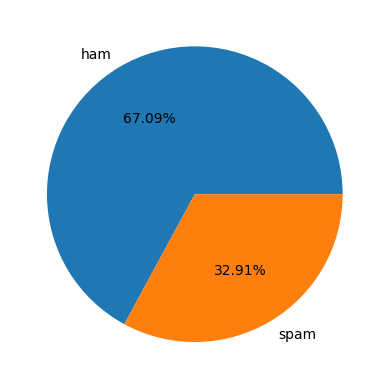

In [32]:
import matplotlib.pyplot as plt
plt.pie(df['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f%%")
plt.show()

3. Text preprocessing

In [33]:
import re
import spacy

# Load mode SpaCy small english
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r"[^\w\s]", "", text)  
    doc = nlp(text)
    words = [token.lemma_ for token in doc if not token.is_stop]

    return " ".join(words)

df["clean_review"] = df["Reviews"].apply(preprocess_text)

print(df[["Reviews", "clean_review"]].head())


                                             Reviews  \
0  This product so far has not disappointed. My c...   
1  great for beginner or experienced person. Boug...   
2  Inexpensive tablet for him to use and learn on...   
3  I've had my Fire HD 8 two weeks now and I love...   
4  I bought this for my grand daughter when she c...   

                                        clean_review  
0  product far disappoint child love use like abi...  
1    great beginner experienced person buy gift love  
2  inexpensive tablet use learn step nabi thrill ...  
3  ve fire hd 8 week love tablet great valuewe pr...  
4  buy grand daughter come visit set user enter a...  


In [34]:
df.head()

,Reviews,label,clean_review
0,This product so far has not disappointed. My c...,1,product far disappoint child love use like abi...
1,great for beginner or experienced person. Boug...,1,great beginner experienced person buy gift love
2,Inexpensive tablet for him to use and learn on...,1,inexpensive tablet use learn step nabi thrill ...
3,I've had my Fire HD 8 two weeks now and I love...,0,ve fire hd 8 week love tablet great valuewe pr...
4,I bought this for my grand daughter when she c...,0,buy grand daughter come visit set user enter a...


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Chỉ lấy 5000 từ phổ biến nhất
X = vectorizer.fit_transform(df["clean_review"])

print(X.shape)  # Số lượng mẫu x số đặc trưng


(5002, 4863)


In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,df['label'],test_size=0.2,random_state=148)

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)  # Tránh lỗi trên sparse matrix
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [46]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()


In [47]:
from lazypredict.Supervised import LazyClassifier  
clf = LazyClassifier().fit(X_train_dense, X_test_dense, y_train, y_test)  
print(clf[0])  # Hiển thị kết quả của 30 mô hình


 97%|█████████▋| 30/31 [08:48<00:13, 13.66s/it]

[LightGBM] [Info] Number of positive: 2690, number of negative: 2690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17551
[LightGBM] [Info] Number of data points in the train set: 5380, number of used features: 470
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 31/31 [08:50<00:00, 17.11s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.72               0.66     0.66      0.71   
AdaBoostClassifier                 0.68               0.65     0.65      0.68   
BernoulliNB                        0.67               0.65     0.65      0.67   
LGBMClassifier                     0.69               0.64     0.64      0.69   
XGBClassifier                      0.68               0.63     0.63      0.68   
ExtraTreesClassifier               0.71               0.63     0.63      0.69   
DecisionTreeClassifier             0.65               0.61     0.61      0.65   
BaggingClassifier                  0.66               0.60     0.60      0.65   
RidgeClassifierCV                  0.61               0.59     0.59      0.62   
NearestCentroid                    0.61               0.59     0.59      0.62   
SVC                         

In [48]:
best_model = clf[0].loc[clf[0]['Accuracy'].idxmax()]
print(best_model)

Accuracy            0.72
Balanced Accuracy   0.66
ROC AUC             0.66
F1 Score            0.71
Time Taken          7.53
Name: RandomForestClassifier, dtype: float64


Use optune to select the best param

In [50]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Hàm mục tiêu để tối ưu
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()
    return score

# Chạy tối ưu
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # Thử 20 lần

# In kết quả
print("Best parameters:", study.best_params)


[I 2025-02-21 14:13:18,897] A new study created in memory with name: no-name-05505ab7-f4c2-4362-9712-04f22c6b5cf0
[I 2025-02-21 14:13:27,660] Trial 0 finished with value: 0.7550185873605948 and parameters: {'n_estimators': 263, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7550185873605948.
[I 2025-02-21 14:13:30,609] Trial 1 finished with value: 0.7431226765799257 and parameters: {'n_estimators': 198, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7550185873605948.
[I 2025-02-21 14:13:35,139] Trial 2 finished with value: 0.754089219330855 and parameters: {'n_estimators': 166, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7550185873605948.
[I 2025-02-21 14:13:50,591] Trial 3 finished with value: 0.7509293680297399 and parameters: {'n_estimators': 416, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value

Best parameters: {'n_estimators': 329, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [51]:
# Kết quả tốt nhất
best_params = study.best_params
print("Best Parameters:", best_params)


Best Parameters: {'n_estimators': 329, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [54]:
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_dense,y_train)
accuracy = best_model.score(X_test_dense, y_test)
print(f"Best Model Accuracy: {accuracy:.4f}")

Best Model Accuracy: 0.7173


*Use GridSearchCV to find best param

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

clf = RandomForestClassifier(random_state=42)

search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [58]:
from sklearn.metrics import accuracy_score, f1_score

best_model = search.best_estimator_

# Bước 4: Dự đoán trên tập test
y_pred = best_model.predict(X_test)

# Bước 5: Tính Accuracy và F1-score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")  # hoặc average="macro"

# In kết quả
print("Best Parameters:", search.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7183
F1-score: 0.7095
